### Import necessary libraries

In [1]:
import os
import sys
import timeit

import numpy as np

import torchxrayvision as xrv
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import KFold

### Check if GPU is available

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

### Load XRay dataset

{'ARDS': {0.0: 95, 1.0: 4},
 'Bacterial Pneumonia': {0.0: 93, 1.0: 6},
 'COVID-19': {0.0: 23, 1.0: 76},
 'MERS': {0.0: 99},
 'No Finding': {0.0: 98, 1.0: 1},
 'Pneumonia': {0.0: 2, 1.0: 97},
 'SARS': {0.0: 88, 1.0: 11},
 'Streptococcus': {0.0: 93, 1.0: 6},
 'Viral Pneumonia': {0.0: 12, 1.0: 87}}
COVID19_Dataset num_samples=99
dict_keys(['PA', 'lab', 'idx'])


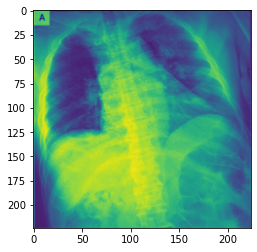

In [3]:
transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(), xrv.datasets.XRayResizer(224)])

data_path = 'covid-chestxray-dataset/'
d_covid19 = xrv.datasets.COVID19_Dataset(imgpath=data_path+'images', csvpath=data_path+'metadata.csv', transform=transform)

print(d_covid19)
print(d_covid19[0].keys())

import matplotlib.pyplot as plt

img = d_covid19[0]['PA']
npimg = img.reshape((224,224))
plt.imshow(npimg)
plt.show()

In [4]:
l   = len(d_covid19)
arr = np.linspace(0,l-1,l)
np.random.shuffle(arr)
np.random.shuffle(arr)

idx = arr.astype(int)

images_data, labels_data = [], []
for ind in idx:
    images_data.append(d_covid19[ind]['PA'])
    labels_data.append(int(d_covid19[ind]['lab'][2]))
    
images_data = np.array(images_data)
labels_data = np.array(labels_data).reshape((-1,1))

### Create datasetloader

In [5]:
class Covid19Dataset(Dataset):
    def __init__(self, images, labels, transforms=None):
        self.data_len = len(images)
        self.images   = images
        self.labels   = labels
        
    def __getitem__(self, index):
        img   = self.images[index,:]
        label = self.labels[index,:]
        
        img   = torch.FloatTensor(img).to(device)
        label = torch.LongTensor(label).to(device)
        
        return (img, label)
    
    def __len__(self):
        return self.data_len

### Define a CNN class

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 25)
        self.pool  = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(4, 16, 19)
        self.fc1   = nn.Linear(16 * 8 * 8, 128)
        self.fc2   = nn.Linear(128, 64)
        self.fc3   = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Hyperparameters

In [7]:
lr_decay       = 0.75
decay_interval = 10
iteration      = 20
num_kfolds     = 5
kfold          = KFold(num_kfolds, True, 1)
criterion      = nn.CrossEntropyLoss()

### Let's put all this together

In [8]:
l        = len(d_covid19)
examples = np.linspace(0,l-1,l).astype(int)

count = 0
for train, test in kfold.split(examples):
    count      += 1
    file_result = 'results_' + str(count) + '-fold.txt'
    file_model  = 'model_' + str(count) + '-fold'
    
    with open(file_result, 'w') as file_writer:
        file_writer.write('Epoch \t Time(sec) \t Loss_train \t Loss_test \t Accuracy \t ROC-AUC \t Precision \t Recall \n')
    
    idx_train = examples[train]
    idx_test  = examples[test]
    
    lr = 1e-4
    torch.manual_seed(1234)
    
    images_train = images_data[idx_train,:]
    labels_train = labels_data[idx_train,:]
    
    images_test  = images_data[idx_test,:]
    labels_test  = labels_data[idx_test,:]
    
    dataset_train = Covid19Dataset(images=images_train, labels=labels_train)
    trainloader   = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=10, shuffle=True)

    dataset_test  = Covid19Dataset(images=images_test, labels=labels_test)
    testloader    = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=4, shuffle=False)
    
    model     = Net().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    start = timeit.default_timer()
    
    print('Training...')
    print('Epoch \t Time(sec) \t Loss_train \t Loss_test \t Accuracy \t ROC-AUC \t Precision \t Recall')
    
    for epoch in range(iteration):
        if (epoch+1) % decay_interval == 0:
            optimizer.param_groups[0]['lr'] *= lr_decay

        running_loss = 0.0
        for data in trainloader:
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss    = criterion(outputs, labels.view(-1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        test_loss = 0.0
        with torch.no_grad():
            score_list, t_list, label_list = [], [], []
            for data in testloader:
                images, labels = data
                outputs        = model(images)
                loss           = criterion(outputs, labels.view(-1))
                test_loss     += loss.item()
                predicted      = F.softmax(outputs,1).to('cpu').data.numpy()
                score_list     = np.append(score_list,predicted[:,1])
                t_list         = np.append(t_list,np.argmax(predicted,1))
                label_list     = np.append(label_list,labels.view(-1).to('cpu').data.numpy())

        try:
            auc   = roc_auc_score(t_list, score_list)
        except:
            auc   = 0.0
        precision = precision_score(t_list, label_list)
        recall    = recall_score(t_list, label_list)
        accuracy  = accuracy_score(t_list, label_list)

        lr_rate = optimizer.param_groups[0]['lr']

        end  = timeit.default_timer()
        time = end - start

        print('%d \t %.4f \t %.4f \t %.4f \t %.4f \t %.4f \t %.4f \t %.4f' %(epoch+1, time, running_loss, test_loss, accuracy, auc, precision, recall))
        
        with open(file_result, 'a') as file_writer:
            result = map(str, [epoch+1, time, running_loss, test_loss, accuracy, auc, precision, recall])
            file_writer.write('\t'.join(result) + '\n')
    
    torch.save(model.state_dict(), file_model)

Training...
Epoch 	 Time(sec) 	 Loss_train 	 Loss_test 	 Accuracy 	 ROC-AUC 	 Precision 	 Recall
1 	 7.2928 	 8.7175 	 2.6132 	 0.7500 	 1.0000 	 0.9167 	 0.7333
2 	 14.5986 	 2.9099 	 2.6617 	 0.7500 	 1.0000 	 0.8333 	 0.7692
3 	 21.8402 	 1.7665 	 5.1781 	 0.7500 	 1.0000 	 0.5833 	 1.0000
4 	 29.2604 	 1.9356 	 3.0698 	 0.8000 	 1.0000 	 0.8333 	 0.8333
5 	 36.6013 	 0.8620 	 3.1176 	 0.7500 	 1.0000 	 0.7500 	 0.8182
6 	 43.7785 	 0.6600 	 2.9314 	 0.7000 	 1.0000 	 0.6667 	 0.8000
7 	 51.1223 	 0.3807 	 2.7744 	 0.8500 	 1.0000 	 0.9167 	 0.8462
8 	 58.5425 	 0.2516 	 3.1655 	 0.7000 	 1.0000 	 0.6667 	 0.8000
9 	 65.8404 	 0.2074 	 3.0542 	 0.8500 	 1.0000 	 0.9167 	 0.8462
10 	 73.1095 	 0.1314 	 3.5256 	 0.7000 	 1.0000 	 0.6667 	 0.8000
11 	 80.4558 	 0.0957 	 3.2959 	 0.8500 	 1.0000 	 0.9167 	 0.8462
12 	 87.7785 	 0.0970 	 3.3006 	 0.8500 	 1.0000 	 0.9167 	 0.8462
13 	 95.2001 	 0.0859 	 3.2009 	 0.8500 	 1.0000 	 0.9167 	 0.8462
14 	 102.6014 	 0.0591 	 3.2930 	 0.8500 	